In [1]:
!pip install scikit-image
!pip install scikit-learn
# Installer tf et keras compatibles avec le Mask RCNN
!pip install tensorflow==1.15 keras==2.3.1 scikit-image==0.17.2

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() #Résous l'erreur d'incompatibilité
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 1.15.0
Keras version: 2.3.1


# Configuration du modèle

In [5]:
# Importation des bibliothèques nécessaires
from mrcnn.config import Config
import mrcnn.model as modellib
import os

# Configuration du modèle
class ChessConfig(Config):
    NAME = "chess_pieces"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 6  # 1 pour le fond, 6 pour les pièces d'échecs
    STEPS_PER_EPOCH = 250
    DETECTION_MIN_CONFIDENCE = 0.9
    LEARNING_RATE = 0.001
    USE_MINI_MASK = False

config = ChessConfig()
config.display()  # Affiche les paramètres de configuration

#Chargement des poids 
#coco_model_path = "C:/Users/ilham/Desktop/IA 2/mask_rcnn_coco.h5"
#Après l'arret du noyau durant l'entrainement Nous reprenons avec le model qui s'est interrompu à la dernière sauvegarde dans le dossier logs (après la première epoch)

# Initialisez le modèle Mask R-CNN en mode "training"
model = modellib.MaskRCNN(mode="training", config=config, model_dir="logs/")

#model.load_weights(coco_model_path, by_name=True, 
                   #exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
#Utilisation directe du chemin vers le modèle interrompu
model.load_weights(r"C:\Users\ilham\Desktop\IA 2\Untitled Folder\logs\chess_pieces20241110T1952\mask_rcnn_chess_pieces_0001.h5", by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
print('Exécuté avec succès')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Création des fichiers d'annotations json

### Données d'entrainement

In [6]:
import os
import json

#Chemin du dataset d'entraînement
train_dir = "C:/Users/ilham/Desktop/IA 2/Données/train"
output_file = "C:/Users/ilham/Desktop/IA 2/Données/train/annotations.json"

#Structure de base pour les annotations
coco_format = {
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 1, "name": "Roi"},
        {"id": 2, "name": "Reine"},
        {"id": 3, "name": "tour"},
        {"id": 4, "name": "fou"},
        {"id": 5, "name": "cavalier"},
        {"id": 6, "name": "pion"}
    ]
}

image_id = 1
annotation_id = 1

#Parcourt chaque catégorie de pièce d'échecs
for category_id, category in enumerate(coco_format["categories"], start=1):
    category_name = category["name"]
    category_dir = os.path.join(train_dir, category_name)

    #Parcourt chaque image et son fichier JSON associé
    for filename in os.listdir(category_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(category_dir, filename)
            json_path = os.path.join(category_dir, filename.replace(".jpg", ".json"))

            #Charge les données json de l'annotation
            with open(json_path) as f:
                data = json.load(f)

            #Ajoute les informations de l'image
            coco_format["images"].append({
                "id": image_id,
                "file_name": os.path.join(category_name, filename),
                "width": data["imageWidth"],
                "height": data["imageHeight"]
            })

            #Ajoute chaque objet annoté
            for obj in data["shapes"]:
                label = obj["label"]
                points = obj["points"]
                
                #Calcule le bounding bbox  à partir des points
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                x_min, y_min = min(x_coords), min(y_coords)
                width, height = max(x_coords) - x_min, max(y_coords) - y_min
                bbox = [x_min, y_min, width, height]

                #Créé la segmentation avec les points
                segmentation = [coord for point in points for coord in point]

                coco_format["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": bbox,
                    "segmentation": [segmentation],
                    "area": bbox[2] * bbox[3],
                    "iscrowd": 0
                })
                annotation_id += 1

            image_id += 1

#Sauvegarde le fichier `annotations.json` dans le dossier train
with open(output_file, "w") as outfile:
    json.dump(coco_format, outfile)

print("Fichier annotations.json train généré avec succès.")


Fichier annotations.json train généré avec succès.


### Données de validation

In [7]:
import os
import json

#Chemin du dataset de validation
val_dir = "C:/Users/ilham/Desktop/IA 2/Données/val"
output_file = "C:/Users/ilham/Desktop/IA 2/Données/val/annotations.json"

#Structure de base pour les annotations
coco_format = {
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 1, "name": "Roi"},
        {"id": 2, "name": "Reine"},
        {"id": 3, "name": "tour"},
        {"id": 4, "name": "fou"},
        {"id": 5, "name": "cavalier"},
        {"id": 6, "name": "pion"}
    ]
}

image_id = 1
annotation_id = 1

#Parcourt chaque catégorie de pièce d'échecs
for category_id, category in enumerate(coco_format["categories"], start=1):
    category_name = category["name"]
    category_dir = os.path.join(val_dir, category_name)

    #Parcourt chaque image et son fichier JSON associé
    for filename in os.listdir(category_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(category_dir, filename)
            json_path = os.path.join(category_dir, filename.replace(".jpg", ".json"))

            #Charge les données JSON de l'annotation
            with open(json_path) as f:
                data = json.load(f)

            #Ajoute les informations de l'image
            coco_format["images"].append({
                "id": image_id,
                "file_name": os.path.join(category_name, filename),
                "width": data["imageWidth"],
                "height": data["imageHeight"]
            })

            #Ajoute chaque objet annoté
            for obj in data["shapes"]:
                label = obj["label"]
                points = obj["points"]

                #Calcule la bbox
                x_coordinates, y_coordinates = zip(*points)
                x_min, y_min = min(x_coordinates), min(y_coordinates)
                x_max, y_max = max(x_coordinates), max(y_coordinates)
                bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

                #Ajoute les points comme segmentation
                segmentation = [coord for point in points for coord in point]

                coco_format["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": bbox,
                    "segmentation": [segmentation],
                    "area": bbox[2] * bbox[3],
                    "iscrowd": 0
                })
                annotation_id += 1

            image_id += 1

#Sauvegarde le fichier `annotations.json` pour le dataset de validation
with open(output_file, "w") as outfile:
    json.dump(coco_format, outfile)

print("Fichier annotations.json généré avec succès pour les données de validation.")


Fichier annotations.json généré avec succès pour les données de validation.


# Chargement des données

In [8]:
from mrcnn.utils import Dataset
import numpy as np
from skimage.draw import polygon
import os
import json

class ChessDataset(Dataset):
    def load_chess(self, dataset_dir, subset):
        # Ajouter les classes
        self.add_class("chess_pieces", 1, "Roi")
        self.add_class("chess_pieces", 2, "Reine")
        self.add_class("chess_pieces", 3, "tour")
        self.add_class("chess_pieces", 4, "fou")
        self.add_class("chess_pieces", 5, "cavalier")
        self.add_class("chess_pieces", 6, "pion")
        
        #Charge les annotations
        annotations_path = os.path.join(dataset_dir, "annotations.json")
        with open(annotations_path) as f:
            annotations = json.load(f)

        #Parcourit chaque image dans le fichier d'annotations
        for image_info in annotations["images"]:
            #Charge les annotations pour l'image
            image_annotations = [
                ann for ann in annotations["annotations"]
                if ann["image_id"] == image_info["id"]
            ]
            
            #Ajoute l'image
            self.add_image(
                "chess_pieces",
                image_id=image_info["id"],
                path=os.path.join(dataset_dir, image_info["file_name"]),
                width=image_info["width"],
                height=image_info["height"],
                annotations=image_annotations
            )

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info["annotations"]

        masks = []
        class_ids = []
        print(f"Chargement des masques pour l'image {image_id}...")

        for annotation in annotations:
            segmentation = annotation["segmentation"]
            
            #Vérifie si la segmentation est une liste vide ou non conforme
            if not segmentation or not isinstance(segmentation[0], list) or len(segmentation[0]) < 2:
                print(f"Attention : Annotation {annotation['id']} pour l'image {image_id} a une segmentation incorrecte.")
                continue

            #Extrait les coordonnées x et y
            x_coords = []
            y_coords = []
            for poly in segmentation:
                x_coords.extend(poly[::2])  # Extraire les coordonnées x
                y_coords.extend(poly[1::2])  # Extraire les coordonnées y

            #Vérifie que les coordonnées ne sont pas vides
            if len(x_coords) == 0 or len(y_coords) == 0:
                print(f"Erreur : Annotation {annotation['id']} pour l'image {image_id} a des coordonnées vides après extraction.")
                continue

            #Crée le masque
            mask = np.zeros((info["height"], info["width"]), dtype=np.uint8)

            # Remplissage du masque
            try:
                rr, cc = polygon(y_coords, x_coords, shape=(info["height"], info["width"]))
                mask[rr, cc] = 1
                masks.append(mask)
                class_ids.append(annotation["category_id"])
            except Exception as e:
                print(f"Erreur lors de la création du masque pour l'annotation {annotation['id']} de l'image {image_id} : {e}")
                continue

        if not masks:
            print(f"Aucun masque valide pour l'image {image_id}.")
            masks = np.empty([0, 0, 0], dtype=np.uint8)
            class_ids = np.array([], dtype=np.int32)
        else:
            masks = np.stack(masks, axis=-1).astype(np.uint8)
            class_ids = np.array(class_ids, dtype=np.int32)

        return masks, class_ids


#Dossiers d'entraînement et de validation
train_dir = "C:/Users/ilham/Desktop/IA 2/Données/train"
val_dir = "C:/Users/ilham/Desktop/IA 2/Données/val"

#Datasets d'entraînement et de validation
dataset_train = ChessDataset()
dataset_train.load_chess(train_dir, "train")  # Charge les données d’entraînement
dataset_train.prepare()

dataset_val = ChessDataset()
dataset_val.load_chess(val_dir, "val")  # Charge les données de validation
dataset_val.prepare()

print("Exécuté avec succès")

Exécuté avec succès


# Entrainement

In [9]:
try:
    model.train(
        dataset_train,
        dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=11,
        layers="heads"
    )
except Exception as e:
    print("Erreur pendant l'entraînement :", e)



Starting at epoch 1. LR=0.001

Checkpoint Path: logs/chess_pieces20241110T1952\mask_rcnn_chess_pieces_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

c:\users\ilham\desktop\ia 2\env2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\ilham\desktop\ia 2\env2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\ilham\desktop\ia 2\env2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "







Epoch 2/11
Chargement des masques pour l'image 386...
 62/250 [======>.......................] - ETA: 1:02:44 - loss: 1.9901Chargement des masques pour l'image 91...


136/250 [===============>..............] - ETA: 35:34 - loss: 1.3921Chargement des masques pour l'image 11...


210/250 [========================>.....] - ETA: 11:59 - loss: 1.1669Chargement des masques pour l'image 455...


249/250 [============================>.] - ETA: 17s - loss: 1.0866Chargement des masques pour l'image 385...
Chargement des masques pour l'image 88...
Chargement des masques pour l'image 103...
Chargement des masques pour l'image 17...
Chargement des masques pour l'image 55...
Chargement des masques pour l'image 87...
Chargement des masques pour l'image 28...
Chargement des masques pour l'image 101...
Chargement des masques pour l'image 20...
Chargement des masques pour l'image 105...
Chargement des masques pour l'image 60...
Chargement des masques pour l'image 109...
Chargement des masques pour l'image 5...
Chargement des masques pour l'image 117...
Chargement des masques pour l'image 42...
Chargement des masques pour l'image 86...
Chargement des masques pour l'image 54...
Chargement des masques pour l'image 96...
Chargement des masques pour l'image 78...
Chargement des masques pour l'image 76...
Chargement des masques pour l'image 11...
Chargement des masques pour l'image 98...
Charg

 86/250 [=========>....................] - ETA: 47:49 - loss: 0.5744Chargement des masques pour l'image 83...


160/250 [==================>...........] - ETA: 27:12 - loss: 0.5972Chargement des masques pour l'image 303...


234/250 [===========================>..] - ETA: 4:47 - loss: 0.5840Chargement des masques pour l'image 89...


249/250 [============================>.] - ETA: 17s - loss: 0.5819Chargement des masques pour l'image 9...
Chargement des masques pour l'image 72...
Chargement des masques pour l'image 33...
Chargement des masques pour l'image 68...
Chargement des masques pour l'image 99...
Chargement des masques pour l'image 118...
Chargement des masques pour l'image 94...
Chargement des masques pour l'image 89...
Chargement des masques pour l'image 40...
Chargement des masques pour l'image 6...
Chargement des masques pour l'image 119...
Chargement des masques pour l'image 47...
Chargement des masques pour l'image 44...
Chargement des masques pour l'image 61...
Chargement des masques pour l'image 115...
Chargement des masques pour l'image 102...
Chargement des masques pour l'image 35...
Chargement des masques pour l'image 41...
Chargement des masques pour l'image 31...
Chargement des masques pour l'image 100...
Chargement des masques pour l'image 116...
Chargement des masques pour l'image 97...
Charge

112/250 [============>.................] - ETA: 39:20 - loss: 0.5450Chargement des masques pour l'image 247...


186/250 [=====================>........] - ETA: 18:12 - loss: 0.5316Chargement des masques pour l'image 357...


249/250 [============================>.] - ETA: 16s - loss: 0.5240Chargement des masques pour l'image 137...
Chargement des masques pour l'image 7...
Chargement des masques pour l'image 15...
Chargement des masques pour l'image 92...
Chargement des masques pour l'image 71...
Chargement des masques pour l'image 14...
Chargement des masques pour l'image 63...
Chargement des masques pour l'image 83...
Chargement des masques pour l'image 84...
Chargement des masques pour l'image 110...
Chargement des masques pour l'image 65...
Chargement des masques pour l'image 2...
Chargement des masques pour l'image 22...
Chargement des masques pour l'image 46...
Chargement des masques pour l'image 75...
Chargement des masques pour l'image 43...
Chargement des masques pour l'image 53...
Chargement des masques pour l'image 107...
Chargement des masques pour l'image 3...
Chargement des masques pour l'image 21...
Chargement des masques pour l'image 32...
Chargement des masques pour l'image 15...
Chargement

Chargement des masques pour l'image 0...
Chargement des masques pour l'image 53...
Chargement des masques pour l'image 72...
Chargement des masques pour l'image 100...
Chargement des masques pour l'image 11...
Chargement des masques pour l'image 95...
Chargement des masques pour l'image 1...
Chargement des masques pour l'image 40...
Chargement des masques pour l'image 67...
Chargement des masques pour l'image 22...
Chargement des masques pour l'image 16...
Chargement des masques pour l'image 105...
Chargement des masques pour l'image 115...
Chargement des masques pour l'image 88...
Chargement des masques pour l'image 86...
Chargement des masques pour l'image 55...
Chargement des masques pour l'image 47...
Chargement des masques pour l'image 76...
Chargement des masques pour l'image 57...
Chargement des masques pour l'image 78...
250/250 [==============================] - 4500s 18s/step - loss: 0.5233 - val_loss: 0.6632
Epoch 5/11
Chargement des masques pour l'image 214...
 64/250 [====

138/250 [===============>..............] - ETA: 30:36 - loss: 0.4983Chargement des masques pour l'image 339...


212/250 [========================>.....] - ETA: 10:22 - loss: 0.4915Chargement des masques pour l'image 35...


249/250 [============================>.] - ETA: 16s - loss: 0.4832Chargement des masques pour l'image 400...
Chargement des masques pour l'image 66...
Chargement des masques pour l'image 60...
Chargement des masques pour l'image 43...
Chargement des masques pour l'image 80...
Chargement des masques pour l'image 7...
Chargement des masques pour l'image 2...
Chargement des masques pour l'image 51...
Chargement des masques pour l'image 87...
Chargement des masques pour l'image 18...
Chargement des masques pour l'image 82...
Chargement des masques pour l'image 12...
Chargement des masques pour l'image 70...
Chargement des masques pour l'image 93...
Chargement des masques pour l'image 119...
Chargement des masques pour l'image 44...
Chargement des masques pour l'image 39...
Chargement des masques pour l'image 84...
Chargement des masques pour l'image 14...
Chargement des masques pour l'image 46...
Chargement des masques pour l'image 74...
Chargement des masques pour l'image 10...
Chargement

 91/250 [=========>....................] - ETA: 43:21 - loss: 0.4186Chargement des masques pour l'image 45...


165/250 [==================>...........] - ETA: 23:10 - loss: 0.4246Chargement des masques pour l'image 263...


239/250 [===========================>..] - ETA: 2:59 - loss: 0.4131Chargement des masques pour l'image 4...


249/250 [============================>.] - ETA: 16s - loss: 0.4130Chargement des masques pour l'image 117...
Chargement des masques pour l'image 62...
Chargement des masques pour l'image 54...
Chargement des masques pour l'image 117...
Chargement des masques pour l'image 29...
Chargement des masques pour l'image 4...
Chargement des masques pour l'image 97...
Chargement des masques pour l'image 94...
Chargement des masques pour l'image 112...
Chargement des masques pour l'image 102...
Chargement des masques pour l'image 118...
Chargement des masques pour l'image 32...
Chargement des masques pour l'image 81...
Chargement des masques pour l'image 35...
Chargement des masques pour l'image 108...
Chargement des masques pour l'image 49...
Chargement des masques pour l'image 71...
Chargement des masques pour l'image 19...
Chargement des masques pour l'image 77...
Chargement des masques pour l'image 90...
Chargement des masques pour l'image 85...
Chargement des masques pour l'image 109...
Char

117/250 [=============>................] - ETA: 36:15 - loss: 0.4164Chargement des masques pour l'image 328...


191/250 [=====================>........] - ETA: 16:17 - loss: 0.3871Chargement des masques pour l'image 456...


249/250 [============================>.] - ETA: 16s - loss: 0.3912Chargement des masques pour l'image 305...
Chargement des masques pour l'image 106...
Chargement des masques pour l'image 75...
Chargement des masques pour l'image 119...
Chargement des masques pour l'image 30...
Chargement des masques pour l'image 17...
Chargement des masques pour l'image 111...
Chargement des masques pour l'image 118...
Chargement des masques pour l'image 29...
Chargement des masques pour l'image 86...
Chargement des masques pour l'image 32...
Chargement des masques pour l'image 35...
Chargement des masques pour l'image 38...
Chargement des masques pour l'image 79...
Chargement des masques pour l'image 36...
Chargement des masques pour l'image 63...
Chargement des masques pour l'image 60...
Chargement des masques pour l'image 14...
Chargement des masques pour l'image 23...
Chargement des masques pour l'image 47...
Chargement des masques pour l'image 73...
Chargement des masques pour l'image 68...
Charg

Chargement des masques pour l'image 48...
Chargement des masques pour l'image 91...
Chargement des masques pour l'image 107...
Chargement des masques pour l'image 93...
Chargement des masques pour l'image 74...
Chargement des masques pour l'image 113...
Chargement des masques pour l'image 44...
250/250 [==============================] - 4392s 18s/step - loss: 0.3912 - val_loss: 0.4244
Epoch 8/11
Chargement des masques pour l'image 71...
 69/250 [=======>......................] - ETA: 49:21 - loss: 0.3425Chargement des masques pour l'image 265...


143/250 [================>.............] - ETA: 29:17 - loss: 0.3507Chargement des masques pour l'image 331...


217/250 [=========================>....] - ETA: 9:01 - loss: 0.3599Chargement des masques pour l'image 242...


249/250 [============================>.] - ETA: 16s - loss: 0.3576Chargement des masques pour l'image 373...
Chargement des masques pour l'image 25...
Chargement des masques pour l'image 87...
Chargement des masques pour l'image 108...
Chargement des masques pour l'image 84...
Chargement des masques pour l'image 6...
Chargement des masques pour l'image 62...
Chargement des masques pour l'image 26...
Chargement des masques pour l'image 117...
Chargement des masques pour l'image 15...
Chargement des masques pour l'image 12...
Chargement des masques pour l'image 39...
Chargement des masques pour l'image 4...
Chargement des masques pour l'image 85...
Chargement des masques pour l'image 8...
Chargement des masques pour l'image 54...
Chargement des masques pour l'image 40...
Chargement des masques pour l'image 53...
Chargement des masques pour l'image 64...
Chargement des masques pour l'image 24...
Chargement des masques pour l'image 83...
Chargement des masques pour l'image 11...
Chargement

 95/250 [==========>...................] - ETA: 42:03 - loss: 0.3818Chargement des masques pour l'image 354...


169/250 [===================>..........] - ETA: 22:02 - loss: 0.3525Chargement des masques pour l'image 169...


243/250 [============================>.] - ETA: 1:54 - loss: 0.3522Chargement des masques pour l'image 87...


249/250 [============================>.] - ETA: 16s - loss: 0.3531Chargement des masques pour l'image 419...
Chargement des masques pour l'image 69...
Chargement des masques pour l'image 59...
Chargement des masques pour l'image 58...
Chargement des masques pour l'image 27...
Chargement des masques pour l'image 98...
Chargement des masques pour l'image 42...
Chargement des masques pour l'image 22...
Chargement des masques pour l'image 61...
Chargement des masques pour l'image 33...
Chargement des masques pour l'image 3...
Chargement des masques pour l'image 109...
Chargement des masques pour l'image 98...
Chargement des masques pour l'image 104...
Chargement des masques pour l'image 65...
Chargement des masques pour l'image 97...
Chargement des masques pour l'image 37...
Chargement des masques pour l'image 3...
Chargement des masques pour l'image 43...
Chargement des masques pour l'image 91...
Chargement des masques pour l'image 49...
Chargement des masques pour l'image 63...
Chargemen

121/250 [=============>................] - ETA: 35:06 - loss: 0.3625Chargement des masques pour l'image 353...


195/250 [======================>.......] - ETA: 14:57 - loss: 0.3432Chargement des masques pour l'image 67...


249/250 [============================>.] - ETA: 16s - loss: 0.3392Chargement des masques pour l'image 37...
Chargement des masques pour l'image 116...
Chargement des masques pour l'image 47...
Chargement des masques pour l'image 35...
Chargement des masques pour l'image 11...
Chargement des masques pour l'image 0...
Chargement des masques pour l'image 77...
Chargement des masques pour l'image 29...
Chargement des masques pour l'image 68...
Chargement des masques pour l'image 25...
Chargement des masques pour l'image 26...
Chargement des masques pour l'image 21...
Chargement des masques pour l'image 40...
Chargement des masques pour l'image 39...
Chargement des masques pour l'image 81...
Chargement des masques pour l'image 80...
Chargement des masques pour l'image 107...
Chargement des masques pour l'image 103...
Chargement des masques pour l'image 51...
Chargement des masques pour l'image 14...
Chargement des masques pour l'image 113...
Chargement des masques pour l'image 8...
Chargeme

 73/250 [=======>......................] - ETA: 48:49 - loss: 0.2899Chargement des masques pour l'image 96...


147/250 [================>.............] - ETA: 28:21 - loss: 0.2961Chargement des masques pour l'image 347...


221/250 [=========================>....] - ETA: 8:01 - loss: 0.2960Chargement des masques pour l'image 15...


249/250 [============================>.] - ETA: 16s - loss: 0.3020Chargement des masques pour l'image 363...
Chargement des masques pour l'image 58...
Chargement des masques pour l'image 10...
Chargement des masques pour l'image 72...
Chargement des masques pour l'image 70...
Chargement des masques pour l'image 7...
Chargement des masques pour l'image 95...
Chargement des masques pour l'image 108...
Chargement des masques pour l'image 84...
Chargement des masques pour l'image 24...
Chargement des masques pour l'image 31...
Chargement des masques pour l'image 33...
Chargement des masques pour l'image 110...
Chargement des masques pour l'image 60...
Chargement des masques pour l'image 9...
Chargement des masques pour l'image 94...
Chargement des masques pour l'image 66...
Chargement des masques pour l'image 85...
Chargement des masques pour l'image 112...
Chargement des masques pour l'image 75...
Chargement des masques pour l'image 79...
Chargement des masques pour l'image 111...
Chargem

# Prédictions

Re-starting from epoch 11


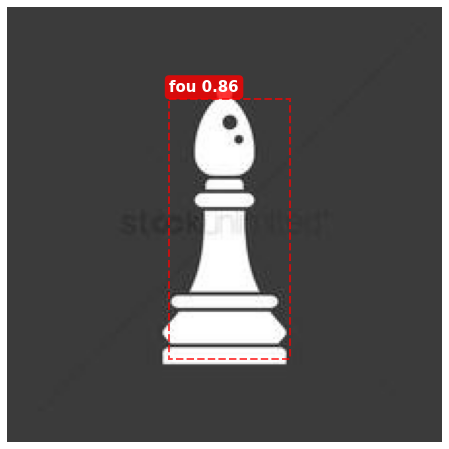

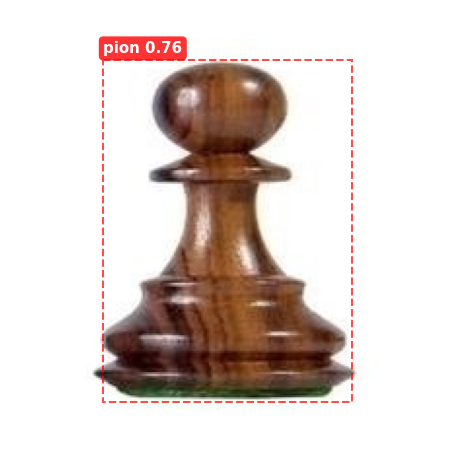

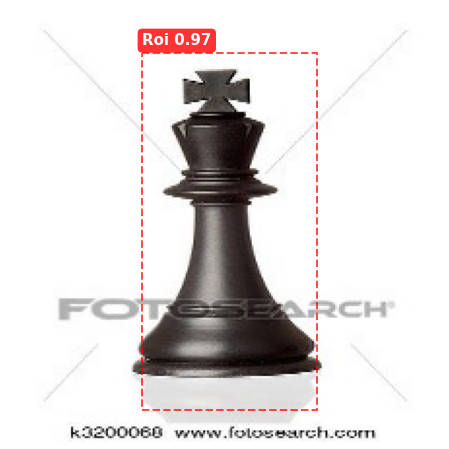

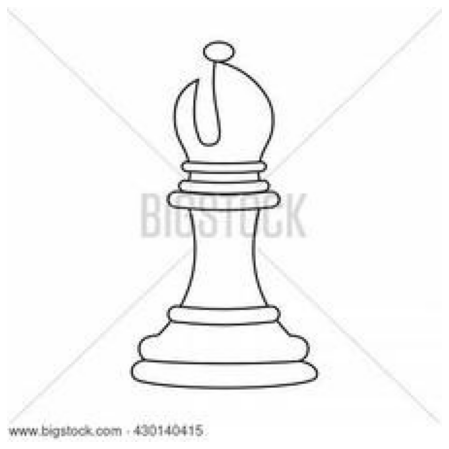

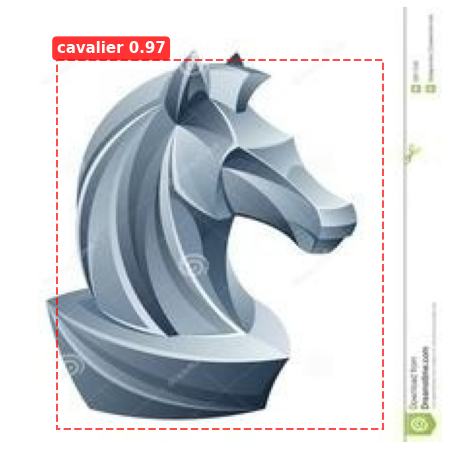

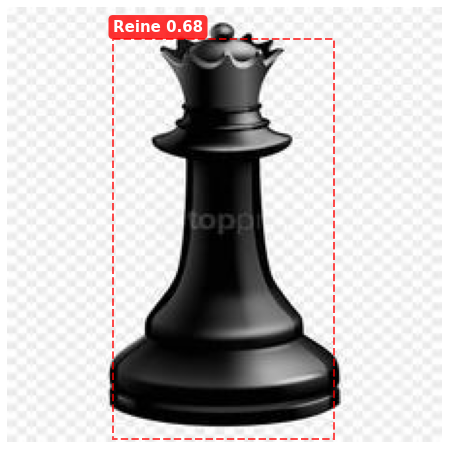

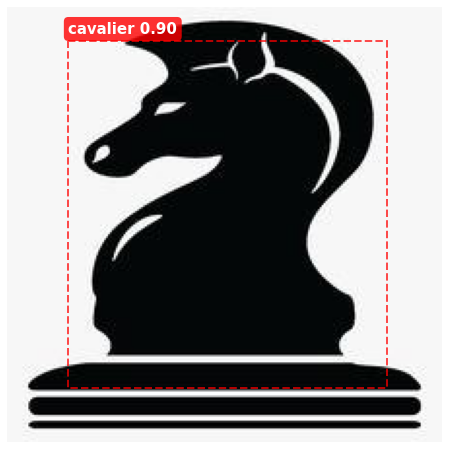

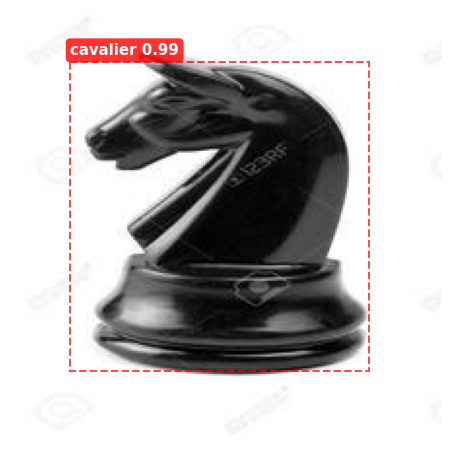

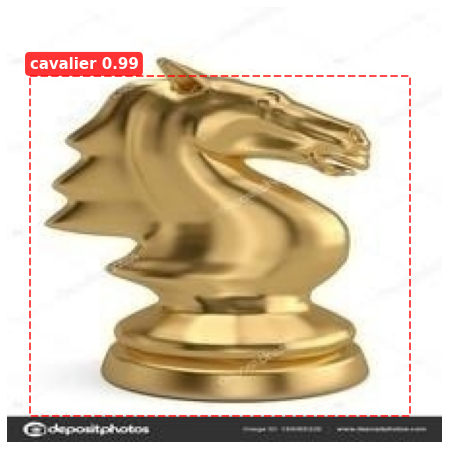

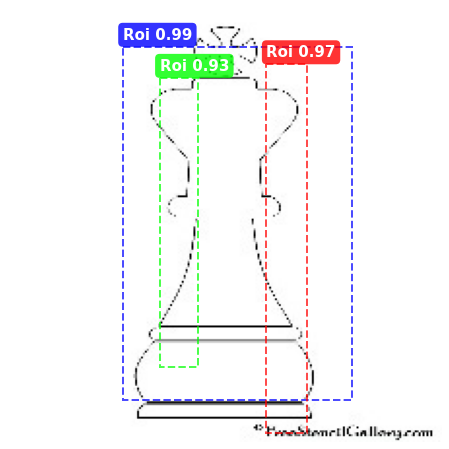

In [41]:
import matplotlib.pyplot as plt
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import visualize
import random
import numpy as np
from mrcnn.visualize import random_colors, apply_mask
import matplotlib.patches as patches

#Configuration pour l'inférence
class InferenceConfig(ChessConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.DETECTION_MIN_CONFIDENCE = 0.6 #

#Modèle mask RCNN en mode inférence
model_inference = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir="logs/")

#Poids entraînés (du modèle entrainé)
model_inference.load_weights(r"C:\Users\ilham\Desktop\IA 2\Untitled Folder\logs\chess_pieces20241110T1952\mask_rcnn_chess_pieces_0011.h5", by_name=True)

#Affichage des prédictions avec un fond contrasté sous les labels (car illisible sinon)
def display_predictions_with_contrast(image, boxes, masks, class_ids, class_names, scores=None, figsize=(8, 8), fontsize=15):
    """
    Affiche les prédictions avec un fond contrasté sous les labels pour une meilleure visibilité.
    """
    #Couleurs
    colors = random_colors(len(class_ids))

    #Création de la figure
    plt.figure(figsize=figsize)
    plt.imshow(image)
    ax = plt.gca()

    #Boucle pour chaque prédiction
    for i in range(boxes.shape[0]):
        color = colors[i]

        #Boite
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        #Masque
        mask = masks[:, :, i]
        image = apply_mask(image, mask, color)

        #Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = f"{label} {score:.2f}" if score else label

        #Contraste sous le texte du label (sinon illisible)
        ax.text(x1, y1 - 10, caption,
                color="white", fontsize=fontsize, fontweight='bold',
                verticalalignment='top', bbox=dict(facecolor=color, alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

    #Afficher l'image finale
    ax.set_axis_off()
    plt.show()

#Echantillon d'images de validation
sample_images = random.sample(dataset_val.image_ids.tolist(), 10)  # Par exemple, 3 images

for image_id in sample_images:
    image = dataset_val.load_image(image_id)
    
    #Prédiction
    results = model_inference.detect([image], verbose=0)
    r = results[0]
    
    #Affichage de la prédiction et du label
    display_predictions_with_contrast(
        image, r['rois'], r['masks'], r['class_ids'], 
        dataset_val.class_names, r['scores'],
        fontsize=15 
    )


# Matrice de confusion

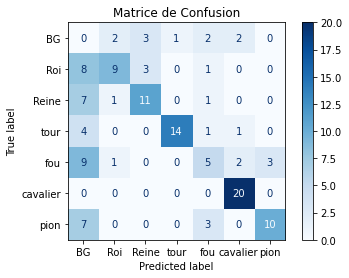

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mrcnn import utils

true_classes = []
predicted_classes = []

#Seuil
IOU_THRESHOLD = 0.5

for image_id in dataset_val.image_ids:
    image = dataset_val.load_image(image_id)
    info = dataset_val.image_info[image_id]
    annotations = info['annotations']
    
    #Extrait les box et les annoations
    gt_boxes = []
    gt_class_ids = []
    for ann in annotations:
        x, y, width, height = ann['bbox']
        gt_boxes.append([y, x, y + height, x + width])  # Format [y1, x1, y2, x2]
        gt_class_ids.append(ann['category_id'])
    
    gt_boxes = np.array(gt_boxes)
    gt_class_ids = np.array(gt_class_ids)
    
    #Prédictions
    results = model_inference.detect([image], verbose=0)
    r = results[0]
    pred_boxes = r['rois']  # Format [y1, x1, y2, x2]
    pred_class_ids = r['class_ids']
    
    #Chevauchement entre prédiction et vraies annotations
    overlaps = utils.compute_overlaps(pred_boxes, gt_boxes)
    
    matched_gt_indices = []
    
    
    for i in range(pred_boxes.shape[0]):
        max_iou = overlaps[i].max()
        gt_match_idx = overlaps[i].argmax()
        
        if max_iou >= IOU_THRESHOLD:
            if gt_match_idx not in matched_gt_indices:
                # Vrai positif
                true_classes.append(gt_class_ids[gt_match_idx])
                predicted_classes.append(pred_class_ids[i])
                matched_gt_indices.append(gt_match_idx)
            else:
                # Faux positif
                true_classes.append(0)
                predicted_classes.append(pred_class_ids[i])
        else:
            # Faux positif (aucune correspondanc)
            true_classes.append(0)
            predicted_classes.append(pred_class_ids[i])
    
    for i in range(len(gt_class_ids)):
        if i not in matched_gt_indices:
            true_classes.append(gt_class_ids[i])
            predicted_classes.append(0) 

#Génération de la matrice
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset_val.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()
